<a href="https://colab.research.google.com/github/HRNPH/ElderVec-FineTuned_Wave2Vec_For_Thai_Eldery/blob/main/ElderVec_StarterPack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get-Started
Load-Datasets

In [1]:
!apt-get install wget

Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [2]:
!rm -r Dataset.zip.*
!rm Dataset.zip
!rm -r /content/Dataset
!echo "Downloading Dataset...."
!echo "1/3..."
!wget -q --show-progress 'https://github.com/VISAI-DATAWOW/Thai-Elderly-Speech-dataset/releases/download/v1.0.0/Dataset.zip.001'
!echo "2/3..."
!wget -q --show-progress 'https://github.com/VISAI-DATAWOW/Thai-Elderly-Speech-dataset/releases/download/v1.0.0/Dataset.zip.002'
!echo "3/3..."
!wget -q --show-progress 'https://github.com/VISAI-DATAWOW/Thai-Elderly-Speech-dataset/releases/download/v1.0.0/Dataset.zip.003'
!echo "Merging..."
!cat ./Dataset.zip* > ./Dataset.zip
!echo "Extracting..."
!7z x Dataset.zip -o./
!echo "---Finished----"

1/3...
Dataset.zip.001     100%[===================>]   1.88G  6.25MB/s    in 4m 6s   
2/3...
Dataset.zip.002     100%[===================>]   1.88G  14.6MB/s    in 1m 57s  
3/3...
Dataset.zip.003     100%[===================>] 997.05M  7.78MB/s    in 94s     
Merging...
Extracting...

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 5072015199 bytes (4838 MiB)

Extracting archive: Dataset.zip
 10% 4096 Open              --
Path = Dataset.zip
Type = zip
Physical Size = 5072015199
64-bit = +

  0%      0% 798 - Dataset/Healthcare/Record/._record_healthcare_7000018_2431.wav                                                                         

# Fine-Tuning

## Setup

In [3]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [4]:
%%capture
!apt-get update
!apt-get install --reinstall build-essential --yes
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip -q install datasets
!pip -q install transformers
!pip -q install jiwer
!pip install ipywidgets
!pip install pythainlp

In [5]:
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import (
    Dataset,
    load_dataset, 
    load_from_disk,
    load_metric,)
from datasets.filesystems import hffilesystem
from transformers import (
    Wav2Vec2CTCTokenizer, 
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    TrainingArguments,
    Trainer,
)
import torchaudio
import re
import json
from pythainlp.tokenize import word_tokenize, syllable_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [6]:
from huggingface_hub import notebook_login
notebook_login()

In [7]:
data = pd.read_json('/content/Dataset/Healthcare/transcription.json').drop(columns='speaker_id')
path = '/content/Dataset/Healthcare/Record/'
fsys = '.wav'
data['filename'] = data['filename'].map(lambda x: path + x + fsys)
data.columns = ['path', 'sentence']

In [8]:
frac = 0.125
samplen = int(data.shape[0] * frac)
test = data.sample(n=samplen , random_state=69420)
train = data.drop(test.index)
valid = train.sample(n=samplen , random_state=69420)
train = train.drop(valid.index)
train = train.reset_index()
test = test.reset_index()
valid = valid.reset_index()

<BarContainer object of 3 artists>

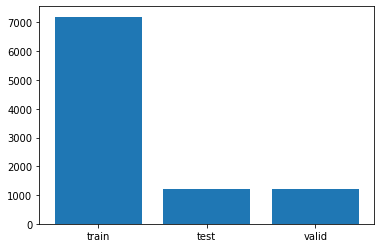

In [9]:
plt.bar(['train', 'test', 'valid'], [train.shape[0], test.shape[0], valid.shape[0]])

In [10]:
train.to_csv('./train.csv', index=False)
test.to_csv('./test.csv', index=False)
valid.to_csv('./valid.csv', index=False)
datasets = load_dataset('csv', data_files={'train':'./train.csv', 'test':'./test.csv', 'valid':'./valid.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7adc8af227646100/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
datasets

DatasetDict({
    train: Dataset({
        features: ['index', 'path', 'sentence'],
        num_rows: 7200
    })
    test: Dataset({
        features: ['index', 'path', 'sentence'],
        num_rows: 1200
    })
    valid: Dataset({
        features: ['index', 'path', 'sentence'],
        num_rows: 1200
    })
})

## Tokenizer

In [12]:
def extract_all_chars(batch, text_col = "sentence"):
    all_text = " ".join(batch[text_col])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = datasets.map(extract_all_chars, 
                   batched=True, 
                   batch_size=-1, 
                   keep_in_memory=True, 
                   remove_columns=datasets.column_names["train"])

vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["valid"]["vocab"][0]) |set(vocabs["test"]["vocab"][0]))
# vocab_list = list(set(vocabs["train"]["vocab"][0])) #strictly no leakage
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
len(vocab_dict), vocab_dict

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

(58,
 {'ผ': 0,
  'ั': 1,
  'ร': 2,
  'ซ': 3,
  '์': 4,
  'ุ': 5,
  'แ': 6,
  'ว': 7,
  'ศ': 8,
  'ด': 9,
  'ฉ': 10,
  'ึ': 11,
  'ล': 12,
  'ษ': 13,
  '๊': 14,
  'า': 15,
  'ท': 16,
  'ฬ': 17,
  'ห': 18,
  '่': 19,
  'ไ': 20,
  'ฟ': 21,
  'เ': 22,
  'ฝ': 23,
  'ี': 24,
  'ข': 25,
  'ส': 26,
  'ญ': 27,
  'ฆ': 28,
  'ม': 29,
  '๋': 30,
  'พ': 31,
  'ป': 32,
  '็': 33,
  '้': 34,
  'ู': 35,
  'ฐ': 36,
  'ใ': 37,
  'ธ': 38,
  'ง': 39,
  'จ': 40,
  'ะ': 41,
  'บ': 42,
  'ช': 43,
  'ย': 44,
  'ำ': 45,
  'ก': 46,
  'น': 47,
  'ค': 48,
  'ิ': 49,
  'ภ': 50,
  'ต': 51,
  'ื': 52,
  'โ': 53,
  ' ': 54,
  'ณ': 55,
  'ถ': 56,
  'อ': 57})

In [13]:
#make space = |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
#padding token serves as blank token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict), vocab_dict

(60,
 {'ผ': 0,
  'ั': 1,
  'ร': 2,
  'ซ': 3,
  '์': 4,
  'ุ': 5,
  'แ': 6,
  'ว': 7,
  'ศ': 8,
  'ด': 9,
  'ฉ': 10,
  'ึ': 11,
  'ล': 12,
  'ษ': 13,
  '๊': 14,
  'า': 15,
  'ท': 16,
  'ฬ': 17,
  'ห': 18,
  '่': 19,
  'ไ': 20,
  'ฟ': 21,
  'เ': 22,
  'ฝ': 23,
  'ี': 24,
  'ข': 25,
  'ส': 26,
  'ญ': 27,
  'ฆ': 28,
  'ม': 29,
  '๋': 30,
  'พ': 31,
  'ป': 32,
  '็': 33,
  '้': 34,
  'ู': 35,
  'ฐ': 36,
  'ใ': 37,
  'ธ': 38,
  'ง': 39,
  'จ': 40,
  'ะ': 41,
  'บ': 42,
  'ช': 43,
  'ย': 44,
  'ำ': 45,
  'ก': 46,
  'น': 47,
  'ค': 48,
  'ิ': 49,
  'ภ': 50,
  'ต': 51,
  'ื': 52,
  'โ': 53,
  'ณ': 55,
  'ถ': 56,
  'อ': 57,
  '|': 54,
  '[UNK]': 58,
  '[PAD]': 59})

In [14]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("airesearch/wav2vec2-large-xlsr-53-th")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
st = datasets['train'][5]['sentence']
st

'ผิวของฉันคันมากเนื่องจากมีปัญหาทางผิว'

In [16]:
tokenizer(st)

{'input_ids': [57, 64, 47, 58, 19, 3, 53, 45, 62, 46, 45, 62, 51, 16, 2, 28, 62, 61, 15, 19, 3, 49, 16, 2, 51, 32, 31, 45, 14, 40, 16, 21, 16, 3, 57, 64, 47], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
result = tokenizer.decode(tokenizer(st).input_ids)
result

'ผิวของฉันคันมากเนื่องจากมีปัญหาทางผิว'

In [18]:
st == result

True

### Create Wav2Vec2 Feature Extractor

In [19]:
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, 
                                             sampling_rate=16000, 
                                             padding_value=0.0, 
                                             do_normalize=True, 
                                             return_attention_mask=False)

In [20]:
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

#### Preprocess

In [21]:
def speech_file_to_array_fn(batch, 
                            text_col="sentence", 
                            fname_col="path",
                            resampling_to=16000):
    speech_array, sampling_rate = torchaudio.load(batch[fname_col])
    resampler=torchaudio.transforms.Resample(sampling_rate, resampling_to)
    batch["speech"] = resampler(speech_array)[0].numpy()
    batch["sampling_rate"] = resampling_to
    batch["target_text"] = batch[text_col]
    return batch

In [22]:
speech_datasets = datasets.map(speech_file_to_array_fn, remove_columns=datasets.column_names["train"])
speech_datasets

  0%|          | 0/7200 [00:00<?, ?ex/s]

  0%|          | 0/1200 [00:00<?, ?ex/s]

  0%|          | 0/1200 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 7200
    })
    test: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 1200
    })
    valid: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 1200
    })
})

In [23]:
#sample sounds
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(speech_datasets["train"]))
print(speech_datasets["train"][rand_int]["target_text"])
ipd.Audio(data=np.asarray(speech_datasets["train"][rand_int]["speech"]), autoplay=True, rate=16000)

ฉันมีปัญหาผิวหนังเป็นผื่นคันแดงแดงคล้ายลมพิษ


In [24]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [25]:
prepared_datasets = speech_datasets.map(prepare_dataset, 
                                        remove_columns=speech_datasets.column_names["train"], 
                                        batch_size=16,
                                        batched=True)

  0%|          | 0/450 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  "`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your "


  0%|          | 0/75 [00:00<?, ?ba/s]

  0%|          | 0/75 [00:00<?, ?ba/s]

In [26]:
prepared_datasets

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 7200
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 1200
    })
    valid: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 1200
    })
})

## Training

### Data Collector

In [27]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [28]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

### Metric

We use word error rate with space as word boundary. We created those spaces using `pythainlp.tokenize.word_tokenize` (2.3.1). We also use character error rate without word boundaries.

In [29]:
wer_metric = load_metric("wer")

In [30]:
wer_metric.compute(predictions=['สวัสดี ค่า ทุก โคน'],references=['สวัสดี ค่ะ ทุก คน'])

0.5

In [31]:
cer_metric = load_metric('cer')

In [32]:
cer_metric.compute(predictions=['สวัสดี ค่า ทุก โคน'],references=['สวัสดี ค่ะ ทุก คน'])

0.11764705882352941

In [33]:
cer_metric.compute(predictions=['สวัสดีค่าทุกโคน'],references=['สวัสดีค่ะทุกคน'])

0.14285714285714285

In [34]:
def compute_metrics(pred, processor, metric):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Model

We use the pretrained `facebook/wav2vec2-large-xlsr-53`. The training script is `scripts/wav2vec_finetune.py`.

In [35]:
model = Wav2Vec2ForCTC.from_pretrained(
    "airesearch/wav2vec2-large-xlsr-53-th",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=70
)

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


We do not finetune the feature extractor layer.

In [36]:
model.freeze_feature_encoder()

In [37]:
training_args = TrainingArguments(
    output_dir="../data/wav2vec2-eldavec-thai",
    group_by_length=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=8,
    metric_for_best_model='wer',
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    num_train_epochs=10,
    fp16=True,
    learning_rate=1e-4,
    warmup_steps=100,
    save_total_limit=3,
    report_to="tensorboard"
)

In [38]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=partial(compute_metrics, metric=wer_metric, processor=processor),
    train_dataset=prepared_datasets["train"],
    eval_dataset=prepared_datasets["valid"],
    tokenizer=processor.feature_extractor,
)

Using cuda_amp half precision backend


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9000
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  "`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can proc

Step,Training Loss,Validation Loss,Wer
100,0.712300,0.087259,0.995000
200,0.146600,0.068604,0.995833
300,0.146800,0.062357,0.995000


/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:1810: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  args.max_grad_norm,
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 8
Saving model checkpoint to ../data/wav2vec2-eldavec-thai/checkpoint-100
Configuration saved in ../data/wav2vec2-eldavec-thai/checkpoint-100/config.json
Model weights saved in ../data/wav2vec2-eldavec-thai/checkpoint-100/pytorch_model.bin
Feature extractor saved in ../data/wav2vec2-eldavec-thai/checkpoint-100/preprocessor_config.json
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can

### Infer a few examples

In [ ]:
with torch.no_grad():
    logits = model(inputs.input_values,).logits

predicted_ids = torch.argmax(logits, dim=-1)

print("Prediction:", processor.batch_decode(predicted_ids))
print("Reference:", test_dataset["sentence"][:2])

### Evaluate on test set

We evaluate the test set on WER with PyThaiNLP 2.3.1 word boundaries and CER without spaces.

In [ ]:
def evaluate(batch):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    inputs = processor(batch["speech"], sampling_rate=16_000, return_tensors="pt", padding=True)

    with torch.no_grad():
        logits = model(inputs.input_values.to(device),).logits

    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_sentence"] = processor.batch_decode(pred_ids)
    return batch

wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
# result = test_dataset.map(evaluate, batched=True, batch_size=8)
# result_df = pd.DataFrame({'sentence':result['sentence'].replace(' ',''), 
#                            'pred_sentence_tok': result['pred_sentence'].replace(' ','')})
# result_df['sentence_tok'] = result_df.sentence.map(lambda x: ' '.join(word_tokenize(x)))
# result_df['pred_sentence'] = result_df.pred_sentence_tok.map(lambda x: ''.join(x.split()))
# #change tokenization to fit pythainlp tokenization
# result_df['pred_sentence_tok'] = result_df.pred_sentence.map(lambda x: ' '.join(word_tokenize(x)))

# from pythainlp.spell import spell_sent

# result_df['pred_sentence_tok_corrected'] = result_df['pred_sentence_tok']\
#     .map(lambda x: ' '.join(spell_sent(x.split(), engine='sympellpy')[0]))
# result_df['pred_sentence_corrected'] = result_df['pred_sentence_tok_corrected']\
#     .map(lambda x: ''.join(x.split()))
# result_df['pred_sentence_tok_corrected'] = result_df.pred_sentence_corrected.map(lambda x: ' '.join(word_tokenize(x)))

# result_df.to_csv('artifacts/result_cv70.csv',index=False)

In [ ]:
result_df = pd.read_csv('artifacts/result_cv70.csv')
result_df

In [ ]:
#wer
wer_metric.compute(predictions=result_df.pred_sentence_tok,references=result_df.sentence_tok)

In [ ]:
#cer
cer_metric.compute(predictions=result_df.pred_sentence,references=result_df.sentence)

We can further improve by spell correction using n-grams from [TNC](http://www.arts.chula.ac.th/ling/tnc/).

In [ ]:
# #install pre version of pythainlp to use; will be available in PyThaiNLP 3.0
# %pip uninstall pythainlp --yes
# %pip install --ignore-requires-python  https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# %pip install symspellpy

In [ ]:
from pythainlp.spell import spell_sent

result_df['pred_sentence_tok_corrected'] = result_df['pred_sentence_tok']\
    .map(lambda x: ' '.join(spell_sent(x.split(), engine='sympellpy')[0]))
result_df['pred_sentence_corrected'] = result_df['pred_sentence_tok_corrected']\
    .map(lambda x: ''.join(x.split()))
result_df['pred_sentence_tok_corrected'] = result_df.pred_sentence_corrected.map(lambda x: ' '.join(word_tokenize(x)))

result_df

In [ ]:
#wer
wer_metric.compute(predictions=result_df.pred_sentence_tok_corrected,references=result_df.sentence_tok)

In [ ]:
#cer
cer_metric.compute(predictions=result_df.pred_sentence_corrected,references=result_df.sentence)

In [ ]:
result_df